# QRS detection

In [2]:
import invalid_sample_detection   as invalid
import matplotlib.pyplot          as plt
import numpy                      as np
import parameters
import wfdb
import socket

%matplotlib inline

# determine the paths for data/annotations based off the computer name
hostname=socket.gethostname()

if hostname=='alistair-pc70':
    data_path = '/data/challenge-2015/data/'
    ann_path = '/data/challenge-2015/ann/'
else:
    data_path = 'sample_data/challenge_training_data/'
    ann_path = 'sample_data/challenge_training_multiann/'

## Helper methods

In [3]:
# Get annotation file type based on channel type and index
def get_ann_type(channel, channel_index, ecg_ann_type): 
    channel_type = invalid.get_channel_type(channel)

    if channel_type == "ECG": 
        ann_type = ecg_ann_type + str(channel_index)
    elif channel_type == "BP": 
        ann_type = 'wabp'
    elif channel_type == "PLETH": 
        ann_type = "wpleth"
    elif channel_type == "Resp": 
        ann_type = ""
    else: 
        raise Exception("Unrecognized ann type")
    
    return ann_type

In [4]:
# Start and end in seconds
def get_annotation_annfs(sample, ann_type, start, end, channel_type): 
    # Check annotation fs with guess of smaller val (DEFAULT_OTHER_FS) to prevent checking out of range data
    ann_fs = parameters.DEFAULT_OTHER_FS

    # Find annotation fs from wfdb.rdann
    annotation = wfdb.rdann(sample, ann_type, sampfrom=start*ann_fs, sampto=end*ann_fs)

    # If rdann's provided ann_fs is valid, use that annotation fs
    if annotation[-1] is not None and annotation[-1] != 0 and isinstance(annotation[-1], (int, float)):  
        ann_fs = annotation[-1]

    # Otherwise, use default annotation fs and print warning if the annotation is not empty
    elif len(annotation[0]) > 0: 
        if channel_type == "ECG": 
            ann_fs = parameters.DEFAULT_ECG_FS
        else: 
            print "Annotation fs defaulted to ", parameters.DEFAULT_OTHER_FS, " for ", sample, ann_type

    # Get proper range of annotation based on annotation fs, only run if different ann_fs from before 
    if ann_fs != parameters.DEFAULT_OTHER_FS: 
        annotation = wfdb.rdann(sample, ann_type, sampfrom=start*ann_fs, sampto=end*ann_fs)
                        
    return annotation, ann_fs

In [5]:
def get_ann_fs(channel_type): 
    if channel_type == "ECG": 
        return parameters.DEFAULT_ECG_FS
    return parameters.DEFAULT_OTHER_FS

In [6]:
# start and end in seconds
def get_annotation(sample, ann_type, ann_fs, start, end): 
    try: 
        annotation = wfdb.rdann(sample, ann_type, sampfrom=start*ann_fs, sampto=end*ann_fs)
    except Exception as e: 
        annotation = []
        print e
    
    return annotation

## Calculating RR intervals

In [1]:
# # Calculate RR intervals in the sample, where start and end in seconds
# def calculate_rr_intervals(sample, ann_type, start, end, channel_type): 
#     annotation, ann_fs = get_annotation_annfs(sample, ann_type, start, end, channel_type)
    
#     # Convert annotations sample numbers into seconds if >0 annotations in signal
#     if len(annotation[0]) > 0: 
#         ann_seconds = annotation[0] / float(ann_fs)
#     else: 
#         return np.array([0.0])
    
#     rr_intervals = np.array([])
#     for index in range(1, np.size(ann_seconds)):
#         rr_intervals = np.append(rr_intervals, round(ann_seconds[index] - ann_seconds[index - 1], 4))

#     return rr_intervals

# sample_name = "b220s"
# start, end = 284, 300
# rr_intervals = calculate_rr_intervals(ann_path + sample_name, 'jqrs1', start, end, "V")
# if len(rr_intervals) > 0: 
#     print "average: ", sum(rr_intervals) / len(rr_intervals)
# print "rr_intervals", rr_intervals

In [7]:
def get_channel_rr_intervals(ann_path, sample_name, channel_index, fields, ecg_ann_type, start=None, end=None):
    if start is None or end is None: 
        # Start and end given in seconds
        start, end, alarm_duration = invalid.get_start_and_end(fields)

    channels = fields['signame']
    channel = channels[channel_index]
    channel_type = invalid.get_channel_type(channel)
    channel_rr_intervals = np.array([])

    ann_type = get_ann_type(channel, channel_index, ecg_ann_type)
    try: 
        annotation, ann_fs = get_annotation_annfs(ann_path + sample_name, ann_type, start, end, channel_type)

        # Convert annotations sample numbers into seconds if >0 annotations in signal
        if len(annotation[0]) > 0: 
            ann_seconds = np.array(annotation[0]) / float(ann_fs)
        else: 
            return np.array([0.0])

        for index in range(1, np.size(ann_seconds)):
            channel_rr_intervals = np.append(channel_rr_intervals, round(ann_seconds[index] - ann_seconds[index - 1], 4))

    except Exception as e: 
        print e

    return channel_rr_intervals

In [8]:
# Start and end given in seconds
def get_rr_dict(ann_path, sample_name, fields, ecg_ann_type, start=None, end=None): 
    rr_dict = {}
    if start is None or end is None: 
        # Start and end given in seconds
        start, end, alarm_duration = invalid.get_start_and_end(fields)    
    
    channels = fields['signame']
    for channel_index in range(len(channels)): 
        channel_name = channels[channel_index]
        channel_type = invalid.get_channel_type(channel_name)
        if channel_type == "Resp": 
            continue
        
        rr_intervals = get_channel_rr_intervals(ann_path, sample_name, channel_index, fields, ecg_ann_type, start, end)
        
        rr_dict[channel_name] = rr_intervals
    
    return rr_dict

## Plotting

In [9]:
# Plot signal together with annotation types on the channel for data ranging from start to end
def plot_annotations(data_path, ann_path, sample_name, ann_types_list, channel, data_fs, start, end): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    channel_name = fields['signame'][channel]
    channel_type = invalid.get_channel_type(channel_name)
    time_vector = np.linspace(start, end, (end-start) * data_fs)
        
    # Plot the time series of the signal
    plt.figure(figsize=[16, 10])
    plt.plot(d, sig[int(start * data_fs):int(end * data_fs), channel], '-',
             color=parameters.COLORS[0], linewidth=2, 
             label=fields['signame'][channel])
    
    if len(ann_types_list) > len(parameters.MARKER_TYPES) or len(ann_types_list) > len(parameters.COLORS)-1: 
        raise RuntimeException("too many types of annotations to plot")
    
    # Plot each annotation type
    for index in range(len(ann_types_list)): 
        ann_type = ann_types_list[index]
        annotation, ann_fs = get_annotation_annfs(ann_path + sample_name, ann_type, start, end, channel_type)
        if len(annotation[0]) == 0: 
            plt.show()
            return
        
        annotation_seconds = annotation[0] / float(ann_fs)
        annotation_y = [ sig[int(ann_time * data_fs), channel] for ann_time in annotation_seconds ]
        plt.plot(annotation_seconds, annotation_y,
             color=parameters.COLORS[index + 1],
             linestyle='none', linewidth=3,
             marker=parameters.MARKER_TYPES[index], markersize=12,
             label=ann_type)
        
    plt.xlabel('Time (seconds)',fontsize=16)
    plt.legend(fontsize=16)
    plt.grid()
    plt.show()

c:\Users\Andrea\Anaconda2\lib\site-packages\wfdb\_rdann.py:209: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  AT = filebytes[bpi, 1] >> 2  # anntype
c:\Users\Andrea\Anaconda2\lib\site-packages\wfdb\_rdann.py:53: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  ts = ts + filebytes[bpi, 0] + 256 * (filebytes[bpi, 1] & 3)
c:\Users\Andrea\Anaconda2\lib\site-packages\wfdb\_rdann.py:216: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  AT = filebytes[bpi, 1] >> 2
c:\Users\Andrea\Anaconda2\lib\site-packages\wfdb\_rdann.py:67: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  chan[ai] = filebytes[bpi, 0]
c:\Users\Andrea\Anaconda2\lib\site-packages\wfdb\_rdann.py:225: VisibleDeprecationWarning: using a non-integer number instead 

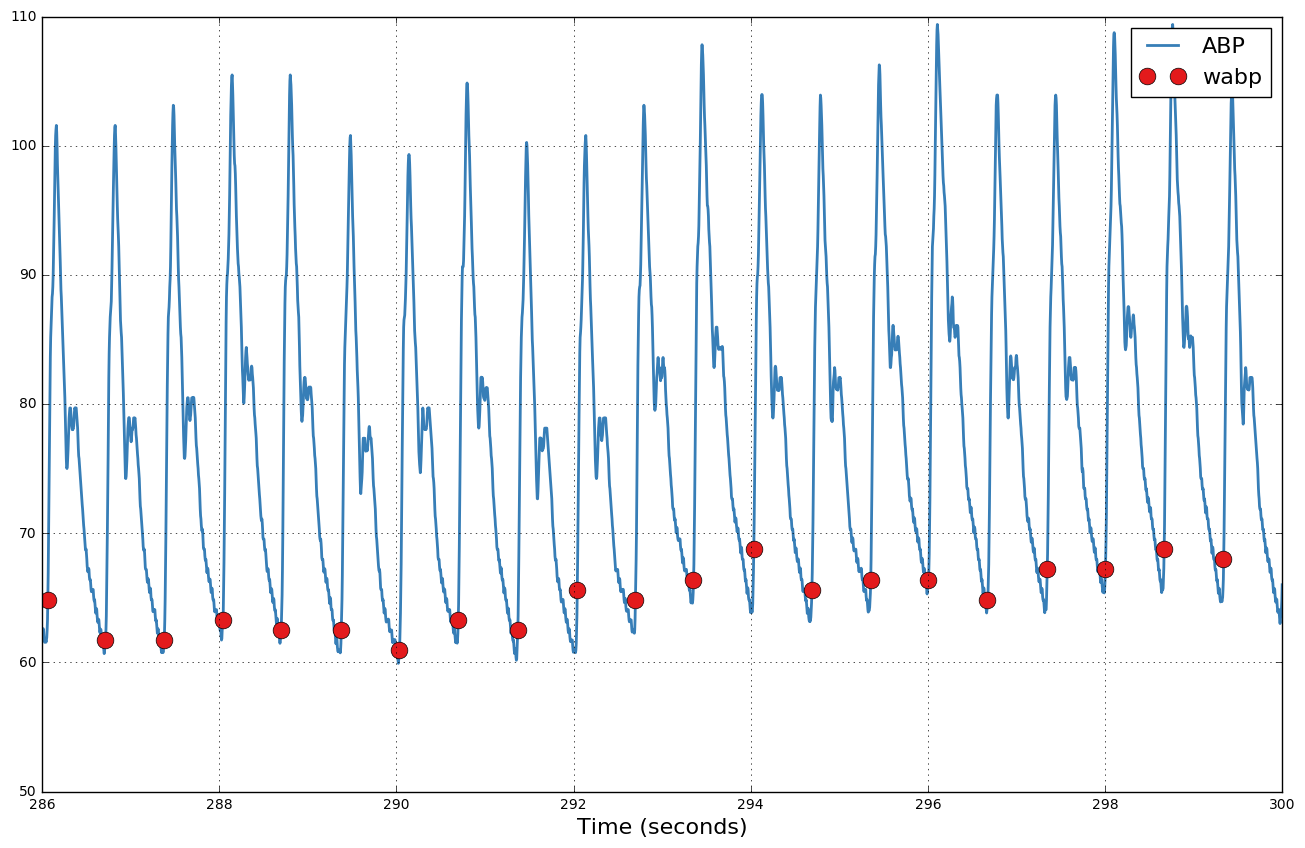

In [10]:
data_fs = 250
sample_name = 't384s'
start = 286
end = 300

# choose the lead to plot (annotations are generated off the first lead)
channel = 2

plot_annotations(data_path, ann_path, sample_name, ['wabp'], channel, data_fs, start, end)